In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Loading the dataset

In [2]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path, low_memory = False)

In [3]:
data.head()

,Unnamed: 0,year,round,from_country,to_country,total_points,tele_points,jury_points,Year_from,iso-alpha-3_from,...,city_to,lat_to,lon_to,GDP per capita (current US$)_to,"Population, total_to",distance,jaccard_artists,jaccard_genre,dice_genre,dice_artists
0,0,1960,final,at,fr,1,NaN,NaN,1960,AUT,...,Paris,3.760847e+06,2.889644e+06,1302.53149729892,47412964,1036.040752,0.153846,0.090909,0.166667,0.266667
1,1,1960,final,at,gb,3,NaN,NaN,1960,AUT,...,London,3.620981e+06,3.203213e+06,1397.5948032844,52400000,1237.492544,0.302326,0.224490,0.366667,0.464286
2,2,1960,final,at,mc,0,NaN,NaN,1960,AUT,...,Monaco,4.111648e+06,2.295892e+06,..,21808,852.872041,0.111111,0.200000,0.333333,0.200000
3,3,1960,final,at,no,1,NaN,NaN,1960,AUT,...,Oslo,4.362948e+06,4.091117e+06,1451.2850779894,3581239,1353.489212,0.292683,0.200000,0.333333,0.452830
4,4,1960,final,at,de,2,NaN,NaN,1960,AUT,...,Berlin,4.551651e+06,3.273670e+06,1162.12266831735,72814900,524.812724,0.666667,0.666667,0.800000,0.800000


## Preprocessing the dataset

In [4]:
# IMPORTANT: No Australia, Morocco and only Grand Final votes

data2 = data[(data["from_country"] != "au") & (data["to_country"] != "au") & (data["round"] == "final") & (data["from_country"] != "ma") & (data["to_country"] != "ma")].copy()

columns_to_use = ["from_country", "to_country", "total_points", "distance","GDP per capita (current US$)_from", "GDP per capita (current US$)_to", "dice_genre", "dice_artists"]
data2.replace("..",float("nan"),inplace=True)
filtered_data = data2[columns_to_use].dropna()

filtered_data["GDP per capita (current US$)_from"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_from"], errors="coerce")
filtered_data["GDP per capita (current US$)_to"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_to"], errors="coerce")
filtered_data["GDP_Difference"] = filtered_data["GDP per capita (current US$)_from"] - filtered_data["GDP per capita (current US$)_to"]

filtered_data["distance_normalized"] = (    # Normalize distance
    filtered_data["distance"] - filtered_data["distance"].mean()
) / filtered_data["distance"].std()

columns_to_use = ["from_country", "to_country", "total_points", "distance", "distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]
filtered_data = filtered_data[columns_to_use]

aggregated_data = filtered_data.groupby(["from_country", "to_country"], as_index = False).agg({
    "total_points": "mean",     # Average points awarded
    "distance": "mean",          # Distance
    "distance_normalized": "mean",
    "GDP_Difference": "mean",
    "dice_genre" : "mean",
    "dice_artists": "mean"
})

aggregated_data["GDP_Difference"] = (     # Normalize GDP
    aggregated_data["GDP_Difference"] - aggregated_data["GDP_Difference"].mean()
) / aggregated_data["GDP_Difference"].std()

aggregated_data



,from_country,to_country,total_points,distance,distance_normalized,GDP_Difference,dice_genre,dice_artists
0,al,am,2.083333,2073.730122,0.436705,-0.019000,1.000000,1.000000
1,al,at,0.875000,808.975149,-0.940228,-1.501414,0.333333,0.200000
2,al,az,3.153846,2507.648698,0.909111,-0.086524,1.000000,1.000000
3,al,ba,5.333333,302.612985,-1.491502,-0.054081,1.000000,1.000000
4,al,be,1.444444,1589.695421,-0.090261,-1.417408,0.333333,0.266667
...,...,...,...,...,...,...,...,...
2050,ua,ru,8.571429,760.610235,-0.992883,-0.282198,0.100000,0.260870
2051,ua,se,4.176471,1269.957029,-0.438359,-1.722038,0.200000,0.200000
2052,ua,si,2.000000,1280.992967,-0.426344,-0.758785,0.200000,0.375000
2053,ua,sm,0.000000,1544.418564,-0.139554,-1.695834,0.200000,0.217391


## Overall Linear Regression for distance (mean)

First, we want to investigate whether the overall distance between the capitals of voting and receiving countries has a significant impact on the average points awarded in the Grand Final over the years.

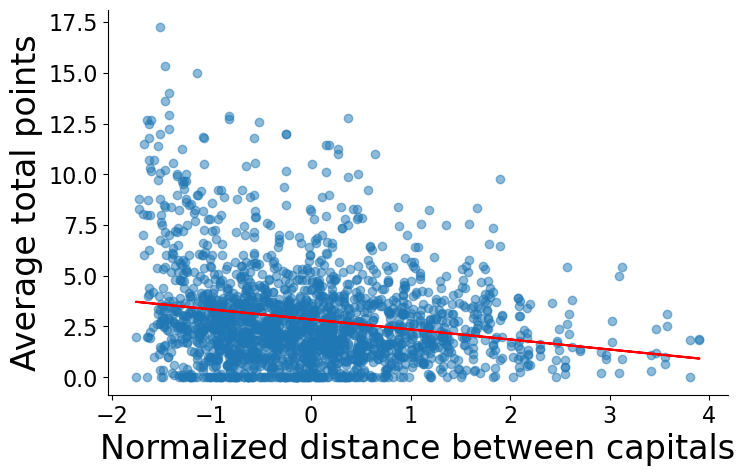

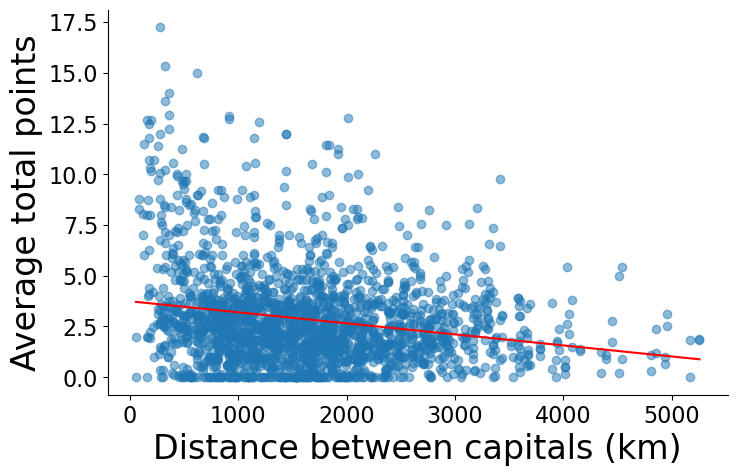

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     89.88
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           6.72e-21
Time:                        14:37:12   Log-Likelihood:                -4658.6
No. Observations:                2055   AIC:                             9321.
Df Residuals:                    2053   BIC:                             9333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8486    

In [5]:
X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["total_points"]

agg_model = sm.OLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

distance_mean = aggregated_data["distance"].mean()      # Unnormalized distance predictions back to original scale for plotting
distance_std = aggregated_data["distance"].std()
x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance_normalized"], aggregated_data["total_points"], alpha = 0.5, label = "Average points by normalized distance")
plt.plot(aggregated_data["distance_normalized"], agg_model.predict(X_agg), color = "red", label = "Regression line")
plt.xlabel("Normalized distance between capitals", fontsize = 24)
plt.ylabel("Average total points", fontsize = 24)
plt.tick_params(axis = "both", which = "major", labelsize = 16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(False)
plt.savefig("../plots/linear_regression/overall_normalized.png", bbox_inches = "tight")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["total_points"], alpha = 0.5, label = "Average points by distance")
plt.plot(x_plot_original, y_plot, color = "red", label = "Regression line")
plt.xlabel("Distance between capitals (km)", fontsize = 24)
plt.ylabel("Average total points", fontsize = 24)
plt.tick_params(axis = "both", which = "major", labelsize = 16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(False)
plt.savefig("../plots/linear_regression/overall.png", bbox_inches = "tight")
plt.show()

print(agg_summary)


### Results explanation

· R²: 0.042 → Only 4.2% of the variance in the average points awarded can be explained by the distance, so distance is not a strong predictor of the overall voting behavior.

· Prob (F-statistic): 6.72e-21 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that distance should have some effect on Eurovision voting, but very small.

· Coefficients:

- Intercept (const): 2.8486 → Represents the predicted average points a country at an average distance from another country would receive.

- Distance Coefficient (normalized): -0.4944 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.

- p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely to be due to random chance).

### Conclusion

Though statistically significant, this effect is very small in magnitude, suggesting that distance only slightly reduces the points awarded.

While distance has a small but significant negative impact on points awarded, the low R² suggests that other factors (such as cultural, political, and historical ties) likely play a much larger role

## Overall Linear Regression with multiple factor (distance, GDP, music preferences)

### Regression with distance

In [6]:
X_full = aggregated_data[["distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]]
X_full = sm.add_constant(X_full)
Y = aggregated_data["total_points"]

model_full = sm.OLS(Y, X_full).fit()
print("Regression including distance:\n", model_full.summary())

Regression including distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     30.05
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           2.48e-24
Time:                        14:37:13   Log-Likelihood:                -4644.1
No. Observations:                2055   AIC:                             9298.
Df Residuals:                    2050   BIC:                             9326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
co

### Results Explanation

· R²: 0.055 → Only 5.5% of the variance in the average points awarded can be explained by the independent variables, meaning that distance, GDP difference, and music similarity do not strongly predict voting behavior in Eurovision.

· Prob (F-statistic): 2.48e-24 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that at least one of the predictors has an effect on Eurovision voting, even if the explanatory power is weak.

· Coefficients:

- Intercept (const): 2.4311 → Represents the predicted average points a country receives at an average distance, GDP difference, and music similarity.

- Distance Coefficient: -0.4452 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount.
- Distance p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely due to random chance).

- GDP Difference Coefficient: -0.0878 → For every 1-standard deviation increase in distance, the expected number of points also decreases by that amount.
- GDP difference p-value (P>|t|): 0.087 → This variable is not statistically significant, meaning GDP difference does not influence Eurovision voting behavior.

- Dice Genre Coefficient: -0.8262 → A higher similarity in music genres leads to slightly fewer points being awarded.
- Genres preference p-value (P>|t|): 0.018 → This effect is statistically significant (p<0.05), so genre similarity does have a small but significant impact on voting.

- Dice Artists Coefficient: 1.7957 → A higher similarity in music artists leads to more points being awarded.
- Artists preference p-value (P>|t|): 0.000 → This effect is highly statistically significant, suggesting that countries with similar top artists tend to give each other more points.

### Conclusion

While distance has a moderate and statistically significant negative impact, its effect remains limited, as shown by the still low R² value.

GDP difference has a small negative effect but is statistically insignificant, so it does not strongly impact Eurovision voting behavior.

Music taste matters more:
- Genre similarity (dice_genre) is statiscally significant, suggesting that shared musical styles have some negative influence on voting patterns, though the effect is relatively small.
- Artist similarity (dice_artists) is highly significant, meaning that countries with overlapping favorite artists tend to vote for each other.

This suggests that Eurovision voting is influenced more by cultural and musical connections rather than economic factors or pure geographic distance.

However, the low R² value indicates that many other factors (such as historical alliances, politics, language, and diaspora voting) likely play a much larger role.



### Regression without distance

Now we are going to rerun the regression without distance to determine how much influence distance had on the model.

If removing distance significantly changes the coefficients, p-values, or R², it would suggest that distance was a key predictor. If nothing changes much, then distance was not contributing significantly to explaining the variation in voting behavior.

In [7]:
X_no_distance = aggregated_data[["GDP_Difference", "dice_genre", "dice_artists"]]
X_no_distance = sm.add_constant(X_no_distance)

model_no_distance = sm.OLS(Y, X_no_distance).fit()
print("\nRegression without distance:\n", model_no_distance.summary())


Regression without distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.72
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           4.14e-10
Time:                        14:37:13   Log-Likelihood:                -4679.3
No. Observations:                2055   AIC:                             9367.
Df Residuals:                    2051   BIC:                             9389.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

### Results Comparison

· R² decreased: (from 0.055 to 0.022) → When distance was removed, the model's explanatory power dropped significantly. This indicates that distance had a notable effect on predicting voting behavior, but it is still weak.

· GDP difference remains statistically insignificant (p=0.087 → p=0.080) → The economic gap between countries continues to have no meaningful influence on Eurovision voting, reinforcing that economic factors do not drive voting behavior.

· Genre coefficient decreased: (from -0.8262 to -1.0771) and Became More Significant (p=0.018 → p=0.002) → In the absence of distance, genre similarity became more negatively impactful and statistically significant. This suggests that countries with similar music genres may vote less for each other, potentially due to preferences for diversity or differentiation in voting.

· Artists coefficient increased: (from 1.7957 to 2.3281) → Artist similarity became even more influential when distance was removed, suggesting that distance and artist similarity were correlated. Countries close to each other not only vote for each other due to proximity but also because they share music artists.

### Analysis of the residuals distribution plot

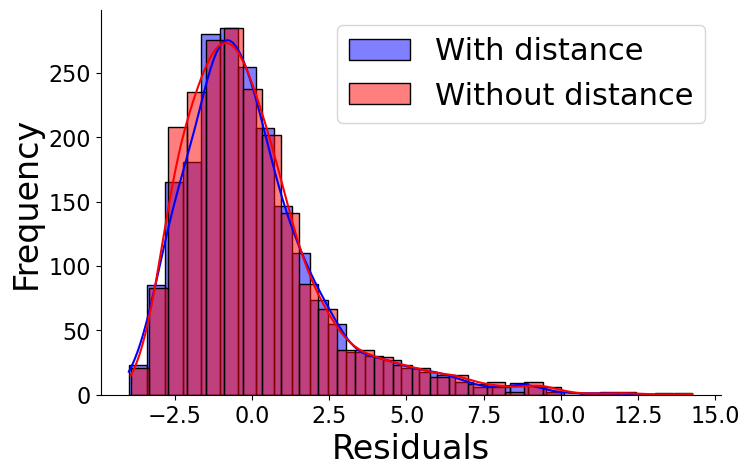

In [8]:
residuals_full = model_full.resid
residuals_no_distance = model_no_distance.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals_full, bins = 30, color = "blue", alpha = 0.5, label = "With distance", kde = True)
sns.histplot(residuals_no_distance, bins = 30, color = "red", alpha = 0.5, label = "Without distance", kde = True)
plt.xlabel("Residuals", fontsize = 24)
plt.ylabel("Frequency", fontsize = 24)
plt.legend(fontsize = 22)
plt.tick_params(axis = "both", which = "major", labelsize = 16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(False)

plt.savefig("../plots/linear_regression/residuals.png", bbox_inches = "tight")
plt.show()

· General shape and distribution:

- The residuals show a right-skewed distribution, meaning the model underpredicts points more often than it overpredicts.

- The majority of residuals are clustered between -2.5 and 2.5, with a peak slightly below 0, indicating that the model's predictions are generally close to actual values but slightly underestimated.

- The long right tail suggests that there are cases where the model fails to capture extreme scores, possibly due to outliers such as politically or culturally aligned countries that award each other more points than expected.

· Comparison: with vs. without distance:

- The blue curve (with distance) and red curve (without distance) are almost identical, meaning that removing distance does not significantly alter the model's error distribution.
- This reinforces the idea that distance is not a key explanatory variable in predicting Eurovision voting behavior.
- The fact that both distributions follow nearly the same trend suggests that other factors (such as artist similarity, genre similarity, or historical voting patterns) are playing a much bigger role.

· Implications for model performance:

- The wide spread of residuals indicates that the model is struggling to capture all the factors influencing voting, since many points awarded deviate significantly from the predictions.
- The right-skewness and extreme values suggest that external sociopolitical and cultural factors are likely influencing Eurovision voting—factors that are not captured by the variables in the model (distance, GDP, genre, and artist similarity).

# Linear Regression Country-wise using only distance (mean)

Fist, we need to obtain a list containing all the participat countries, so we can iterate over them:

In [9]:
participant_countries = filtered_data["from_country"].unique()
print(participant_countries)

['at' 'be' 'dk' 'fr' 'de' 'it' 'lu' 'nl' 'no' 'se' 'ch' 'gb' 'fi' 'es'
 'pt' 'ie' 'mc' 'mt' 'il' 'gr' 'tr' 'cy' 'is' 'ba' 'hr' 'si' 'ee' 'hu'
 'pl' 'ro' 'ru' 'sk' 'mk' 'lt' 'lv' 'ua' 'al' 'by' 'bg' 'md' 'am' 'cz'
 'ge' 'me' 'rs' 'az' 'sm']


Once obtained, we have to set the analysis that is going to be done to every country:

In [10]:
def analyze_country_data_only_distance(country_code, save = False):

    country_info_path = "../data/country_info.csv"
    country_info = pd.read_csv(country_info_path)

    country_row = country_info[country_info["code"].str.lower() == country_code.lower()]    # Map the country code to its corresponding country 
    if country_row.empty:
        print(f"Country {country_code} not found in the country information dataset.")
        return
    country_name = country_row["name"].values[0]

    country_data = aggregated_data[aggregated_data["from_country"] == country_code]
    X_agg = sm.add_constant(country_data["distance_normalized"])
    Y_agg = country_data["total_points"]

    agg_model = sm.OLS(Y_agg, X_agg).fit()
    agg_summary = agg_model.summary()

    
    plt.figure(figsize=(8, 5))
    plt.scatter(country_data["distance_normalized"], country_data["total_points"], alpha=0.5, label="Average points by normalized distance")
    plt.plot(country_data["distance_normalized"], agg_model.predict(X_agg), color="red", label="Regression line")
    plt.title(f"Linear Regression country-wise: Average Points vs. Normalized Distance ({country_name} - {country_code})")
    plt.xlabel("Normalized distance between capitals")
    plt.ylabel("Average total points")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"../plots/linear_regression/{country_name}_{country_code}_normalized.png")
    #plt.show()
    plt.close()

    p_value = agg_model.pvalues["distance_normalized"]
    coefficient = agg_model.params["distance_normalized"]
    #print(agg_summary)

    return country_name, p_value, coefficient, agg_model.resid

We want to separate the countries into two lists: in one of them we will add the countries whose p-value is significant (applying Bonferroni COrrection) and in the other, those that do not, both being ordered from lowest to highest p-value.


Significant countries (p < 0.0010638297872340426):
North Macedonia: p-value = 0.000035 - coefficient = -2.299290
Estonia: p-value = 0.000054 - coefficient = -1.685443
Montenegro: p-value = 0.000208 - coefficient = -2.369881
Georgia: p-value = 0.001023 - coefficient = -1.365022

Non-significant countries (p < 0.0010638297872340426):
Iceland: p-value = 0.001090 - coefficient = -0.886255
Latvia: p-value = 0.001203 - coefficient = -1.501218
Azerbaijan: p-value = 0.001916 - coefficient = -1.377790
Serbia: p-value = 0.002458 - coefficient = -2.006528
Albania: p-value = 0.003255 - coefficient = -1.683812
Bosnia and Herzegovina: p-value = 0.004693 - coefficient = -1.389795
Croatia: p-value = 0.005191 - coefficient = -1.407688
Slovenia: p-value = 0.009079 - coefficient = -1.291636
Norway: p-value = 0.029525 - coefficient = -0.648455
Denmark: p-value = 0.044943 - coefficient = -0.693477
Finland: p-value = 0.056639 - coefficient = -0.679693
Bulgaria: p-value = 0.057946 - coefficient = -0.923046


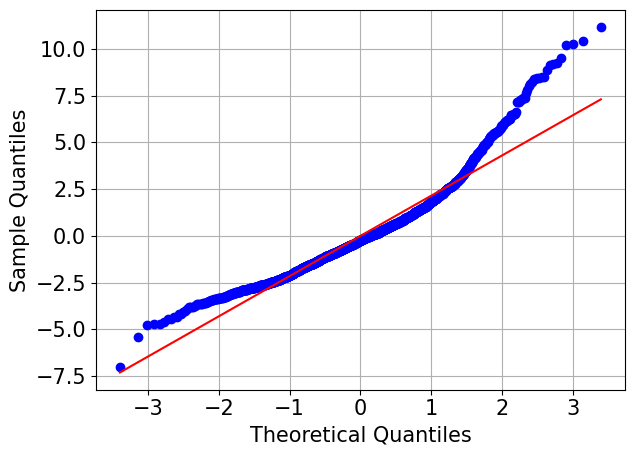

In [11]:

def q_q_plot(all_residuals, mode ): # we will resuse this function to plot the qq plot for all countries
    with plt.rc_context({'font.size': 15}):
        stats.probplot(all_residuals, dist="norm", plot=plt)
        plt.title("")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"../plots/linear_regression/qqplot_all_countries{mode}.png", bbox_inches='tight')
        
        return plt.show()


significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data_only_distance(country, save = False)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

q_q_plot(all_residuals, "_only_distance")

The residuals do not follow a normal distribution, which can be problematic for the validity of the linear regression results.

The central part of the graph follows the red line, so the residuals in this region approximately follow a normal distribution.

This pattern is characteristic of a distribution with heavier tails than the normal distribution (e.g., a t-Student distribution, skewed data), but it also may imply heteroscedasticity.

### Checking heteroscedascity

In [12]:
import statsmodels.stats.diagnostic as smd
smd.het_breuschpagan(all_residuals, X_agg)


(3.4072078862698865,
 0.06491219182971938,
 3.409544924022191,
 0.0649641649327648)

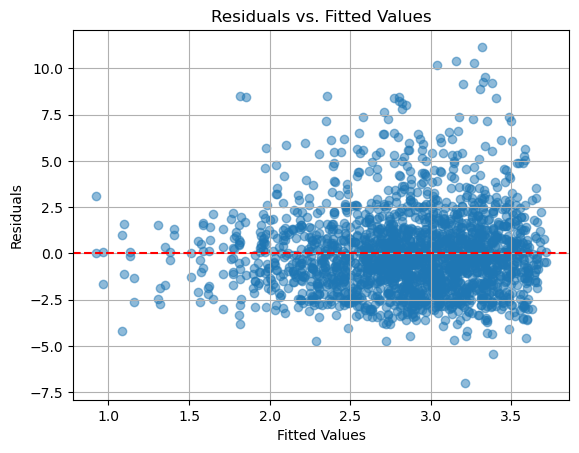

In [13]:
import matplotlib.pyplot as plt

fitted_values = X_agg @ agg_model.params  # Predicted values
plt.scatter(fitted_values, all_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.savefig("../plots/linear_regression/residuals_vs_fitted_values.png")
plt.show()


### Checking if GLS would improve the performance

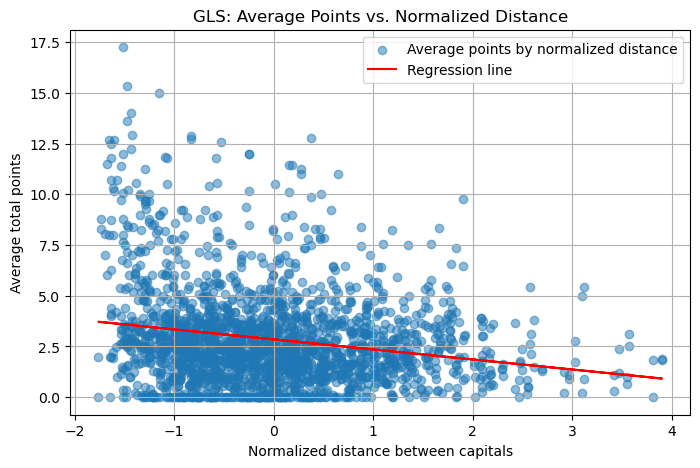

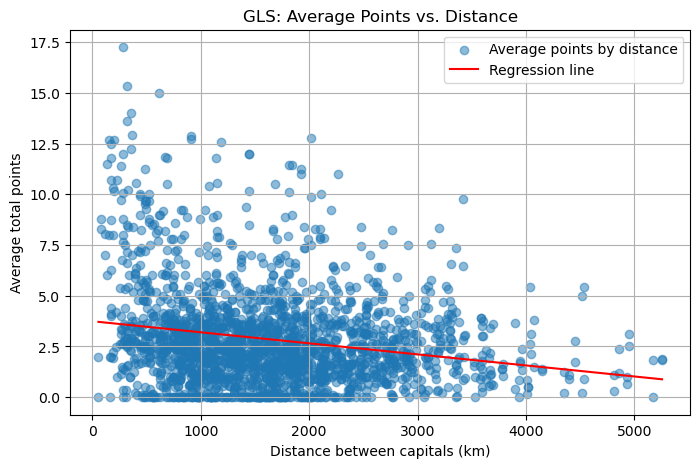

                            GLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.042
Model:                            GLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     89.88
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           6.72e-21
Time:                        14:37:15   Log-Likelihood:                -4658.6
No. Observations:                2055   AIC:                             9321.
Df Residuals:                    2053   BIC:                             9333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8486    

In [14]:
X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["total_points"]

agg_model = sm.GLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

distance_mean = aggregated_data["distance"].mean()      # Unnormalized distance predictions back to original scale for plotting
distance_std = aggregated_data["distance"].std()
x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance_normalized"], aggregated_data["total_points"], alpha=0.5, label="Average points by normalized distance")
plt.plot(aggregated_data["distance_normalized"], agg_model.predict(X_agg), color="red", label="Regression line")
plt.title("GLS: Average Points vs. Normalized Distance")
plt.xlabel("Normalized distance between capitals")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
#plt.savefig("../plots/linear_regression/GLS_overall_normalized.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["total_points"], alpha=0.5, label="Average points by distance")
plt.plot(x_plot_original, y_plot, color="red", label="Regression line")
plt.title("GLS: Average Points vs. Distance")
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
#plt.savefig("../plots/linear_regression/GLS_overall.png")
plt.show()

print(agg_summary)

As we can see, we obtain exactly the same results, meaning that the assumptions of OLS are not strongly violated and that the error variance is constant across observations.

It does not seems to be heteroscedastic.

# Linear Regression Country-wise using all (not religion) (mean)

In [15]:
def analyze_country_data(country_code, save = False):

    country_info_path = "../data/country_info.csv"
    country_info = pd.read_csv(country_info_path)

    country_row = country_info[country_info["code"].str.lower() == country_code.lower()]    # Map the country code to its corresponding country 
    if country_row.empty:
        print(f"Country {country_code} not found in the country information dataset.")
        return
    country_name = country_row["name"].values[0]

    country_data = aggregated_data[aggregated_data["from_country"] == country_code]
    X_full = country_data[["distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]]
    X_agg = sm.add_constant(X_full)
    Y_agg = country_data["total_points"]

    agg_model = sm.OLS(Y_agg, X_agg).fit()
    agg_summary = agg_model.summary()
    
    p_value = agg_model.pvalues["distance_normalized"]
    coefficient = agg_model.params["distance_normalized"]
    #print(agg_summary)

    return country_name, p_value, coefficient, agg_model.resid


Significant countries (p < 0.0010638297872340426):
Estonia: p-value = 0.000227 - coefficient = -1.542720
North Macedonia: p-value = 0.000584 - coefficient = -1.896737

Non-significant countries (p < 0.0010638297872340426):
Montenegro: p-value = 0.001551 - coefficient = -1.771917
Georgia: p-value = 0.002723 - coefficient = -1.590387
Latvia: p-value = 0.003118 - coefficient = -1.412488
Albania: p-value = 0.004846 - coefficient = -1.720351
Czechia: p-value = 0.014537 - coefficient = 1.363617
Azerbaijan: p-value = 0.014982 - coefficient = -1.295728
Slovenia: p-value = 0.015835 - coefficient = -1.170796
Serbia: p-value = 0.017070 - coefficient = -1.696606
Bosnia and Herzegovina: p-value = 0.019922 - coefficient = -1.170224
Iceland: p-value = 0.020068 - coefficient = -0.727397
Croatia: p-value = 0.038418 - coefficient = -0.894554
Finland: p-value = 0.048948 - coefficient = -0.706424
Belgium: p-value = 0.050763 - coefficient = 0.619458
Netherlands: p-value = 0.065100 - coefficient = 0.480150

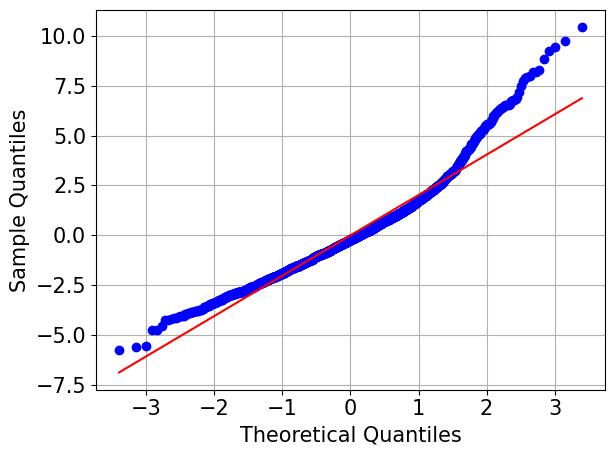

In [16]:
significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data(country)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

q_q_plot(all_residuals, "")

# MEDIAN istead of MEAN

In [17]:
# IMPORTANT: No Australia, Morocco and only Grand Final votes

data3 = data[(data["from_country"] != "au") & (data["to_country"] != "au") & (data["round"] == "final") & (data["from_country"] != "ma") & (data["to_country"] != "ma")].copy()

columns_to_use = ["from_country", "to_country", "total_points", "distance","GDP per capita (current US$)_from", "GDP per capita (current US$)_to", "dice_genre", "dice_artists"]
data2.replace("..",float("nan"),inplace=True)
filtered_data = data2[columns_to_use].dropna()

filtered_data["GDP per capita (current US$)_from"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_from"], errors="coerce")
filtered_data["GDP per capita (current US$)_to"] = pd.to_numeric(filtered_data["GDP per capita (current US$)_to"], errors="coerce")
filtered_data["GDP_Difference"] = filtered_data["GDP per capita (current US$)_from"] - filtered_data["GDP per capita (current US$)_to"]

filtered_data["distance_normalized"] = (    # Normalize distance
    filtered_data["distance"] - filtered_data["distance"].mean()
) / filtered_data["distance"].std()

columns_to_use = ["from_country", "to_country", "total_points", "distance", "distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]
filtered_data = filtered_data[columns_to_use]

aggregated_data = filtered_data.groupby(["from_country", "to_country"], as_index = False).agg({
    "total_points": "median",     # Average points awarded
    "distance": "mean",          # Distance
    "distance_normalized": "mean",
    "GDP_Difference": "mean",
    "dice_genre" : "mean",
    "dice_artists": "mean"
})

aggregated_data["GDP_Difference"] = (     # Normalize GDP
    aggregated_data["GDP_Difference"] - aggregated_data["GDP_Difference"].mean()
) / aggregated_data["GDP_Difference"].std()

aggregated_data

,from_country,to_country,total_points,distance,distance_normalized,GDP_Difference,dice_genre,dice_artists
0,al,am,0.0,2073.730122,0.436705,-0.019000,1.000000,1.000000
1,al,at,0.0,808.975149,-0.940228,-1.501414,0.333333,0.200000
2,al,az,2.0,2507.648698,0.909111,-0.086524,1.000000,1.000000
3,al,ba,6.0,302.612985,-1.491502,-0.054081,1.000000,1.000000
4,al,be,0.0,1589.695421,-0.090261,-1.417408,0.333333,0.266667
...,...,...,...,...,...,...,...,...
2050,ua,ru,10.0,760.610235,-0.992883,-0.282198,0.100000,0.260870
2051,ua,se,4.0,1269.957029,-0.438359,-1.722038,0.200000,0.200000
2052,ua,si,1.5,1280.992967,-0.426344,-0.758785,0.200000,0.375000
2053,ua,sm,0.0,1544.418564,-0.139554,-1.695834,0.200000,0.217391


## Overall Linear Regression for distance (median)

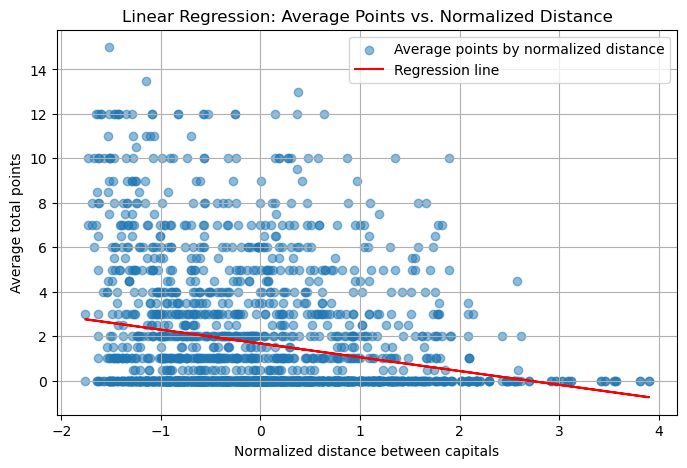

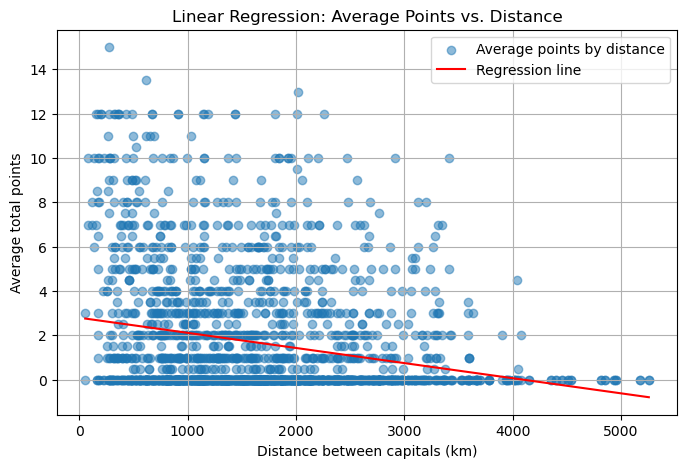

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     107.8
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.20e-24
Time:                        14:37:16   Log-Likelihood:                -4936.5
No. Observations:                2055   AIC:                             9877.
Df Residuals:                    2053   BIC:                             9888.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.6738    

In [18]:
X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["total_points"]

agg_model = sm.OLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

distance_mean = aggregated_data["distance"].mean()      # Unnormalized distance predictions back to original scale for plotting
distance_std = aggregated_data["distance"].std()
x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance_normalized"], aggregated_data["total_points"], alpha=0.5, label="Average points by normalized distance")
plt.plot(aggregated_data["distance_normalized"], agg_model.predict(X_agg), color="red", label="Regression line")
plt.title("Linear Regression: Average Points vs. Normalized Distance")
plt.xlabel("Normalized distance between capitals")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_normalized_median.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["total_points"], alpha=0.5, label="Average points by distance")
plt.plot(x_plot_original, y_plot, color="red", label="Regression line")
plt.title("Linear Regression: Average Points vs. Distance")
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_median.png")
plt.show()

print(agg_summary)

### Results explanation

· R²: 0.050 → 5.0% - Similar to using mean (4.2%)

· Prob (F-statistic): 1.20e-24 → using mean 6.72e-21

· Coefficients:

- Intercept (const): 1.6738 → Represents the predicted median points a country at an average distance from another country would receive. Similar to mean (2.8486)

- Distance Coefficient (normalized): -0.6198 → For every 1-standard deviation increase in distance, the expected number of points decreases by that amount. Similar to mean (-0.4944)

- p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely to be due to random chance). Exactly the same as mean.

## Overall Linear Regression with multiple factor (distance, GDP, music preferences)

### Regression with distance

In [19]:
X_full = aggregated_data[["distance_normalized", "GDP_Difference", "dice_genre", "dice_artists"]]
X_full = sm.add_constant(X_full)
Y = aggregated_data["total_points"]

model_full = sm.OLS(Y, X_full).fit()
print("Regression including distance:\n", model_full.summary())

Regression including distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     33.03
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           9.98e-27
Time:                        14:37:16   Log-Likelihood:                -4924.9
No. Observations:                2055   AIC:                             9860.
Df Residuals:                    2050   BIC:                             9888.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
co

· R²: 0.061 - Similar to mean (0.055)

· Prob (F-statistic): 9.98e-27 - Similar to mean 2.48e-24

· Coefficients:

- Intercept (const): 1.1808 - mean: 2.4311

- Distance Coefficient: -0.5727 - mean: -0.4452
- Distance p-value (P>|t|): 0.000 → mean: 0.000

- GDP Difference Coefficient: 0.0479 - mean: -0.0878
- GDP difference p-value (P>|t|): 0.415 - mean: 0.087 → EVEN MORE NOT SIGNIFICANT

- Dice Genre Coefficient: -0.1923 - mean: -0.8262
- Genres preference p-value (P>|t|): 0.632 - mean: 0.018 → NOW NOT SIGNIFICANT.

- Dice Artists Coefficient: 1.5582 - mean: 1.7957
- Artists preference p-value (P>|t|): 0.000 - mean: 0.000

### Conclusion

Similar results, but Genres are now not significant

### Regression without distance

In [20]:
X_no_distance = aggregated_data[["GDP_Difference", "dice_genre", "dice_artists"]]
X_no_distance = sm.add_constant(X_no_distance)

model_no_distance = sm.OLS(Y, X_no_distance).fit()
print("\nRegression without distance:\n", model_no_distance.summary())


Regression without distance:
                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     13.47
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.05e-08
Time:                        14:37:16   Log-Likelihood:                -4969.0
No. Observations:                2055   AIC:                             9946.
Df Residuals:                    2051   BIC:                             9969.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

### Results Comparison

· R² decreased: (from 0.061 to 0.019) → Also decrease as with mean.

· GDP difference remains statistically insignificant (p=0.0479 → p=0.0469) → Also remains not significant, as with mean.

· Genre coefficient decreased: (from -0.1923 to -0.5150) and Became More Significant (p=0.632 → p=0.208) → Remains not significant, but it is with mean.

· Artists coefficient increased: (from 1.5582 to 2.2431) → Same as mean, p=0.000 and highly significant.

### Analysis of the residuals distribution plot

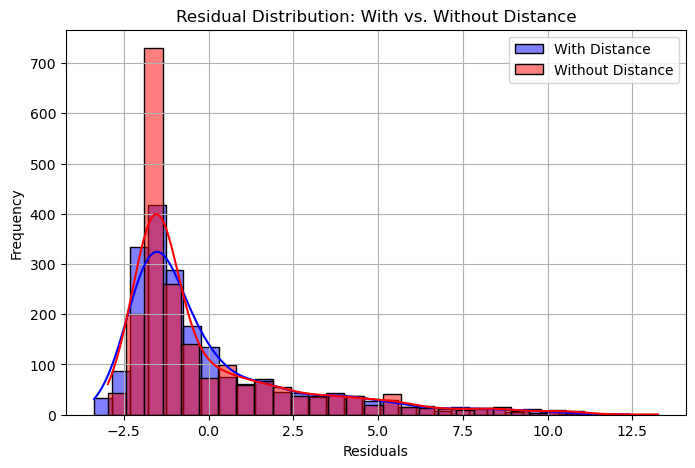

In [21]:
residuals_full = model_full.resid
residuals_no_distance = model_no_distance.resid

plt.figure(figsize=(8, 5))
sns.histplot(residuals_full, bins=30, color="blue", alpha=0.5, label="With Distance", kde=True)
sns.histplot(residuals_no_distance, bins=30, color="red", alpha=0.5, label="Without Distance", kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution: With vs. Without Distance")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/residuals_median.png")
plt.show()

- The median-based approach provides a clearer central tendency and reduces the impact of extreme values.
- The mean-based approach offers a more traditional view of the distribution but is more affected by large deviations.
- Both graphs show that removing distance affects residuals, but the impact is more apparent when using the median.

· MEDIAN: Better for assessing systematic bias → If you suspect that certain countries always receive slightly higher or lower points than expected, the median highlights that bias more clearly.

· MEAN: Better for evaluating variance and error distribution → Since the mean reflects the influence of all data points, it helps when checking for patterns like heteroscedasticity (uneven spread of residuals).

# Linear Regression Country-wise using only distance (median)


Significant countries (p < 0.0010638297872340426):
North Macedonia: p-value = 0.000145 - coefficient = -2.161263
Montenegro: p-value = 0.000165 - coefficient = -2.386643
Georgia: p-value = 0.000192 - coefficient = -1.718094
Estonia: p-value = 0.000261 - coefficient = -1.691597
Latvia: p-value = 0.000375 - coefficient = -1.824995
Azerbaijan: p-value = 0.000442 - coefficient = -1.742346
Croatia: p-value = 0.000549 - coefficient = -2.057072
Serbia: p-value = 0.000729 - coefficient = -2.302425

Non-significant countries (p < 0.0010638297872340426):
Albania: p-value = 0.001142 - coefficient = -2.092717
Slovenia: p-value = 0.002497 - coefficient = -1.802533
Bosnia and Herzegovina: p-value = 0.002947 - coefficient = -1.799128
Iceland: p-value = 0.006584 - coefficient = -0.831044
Norway: p-value = 0.011353 - coefficient = -0.857803
Romania: p-value = 0.015561 - coefficient = -1.224318
Armenia: p-value = 0.021011 - coefficient = -1.175000
Cyprus: p-value = 0.021685 - coefficient = -1.066935
Ru

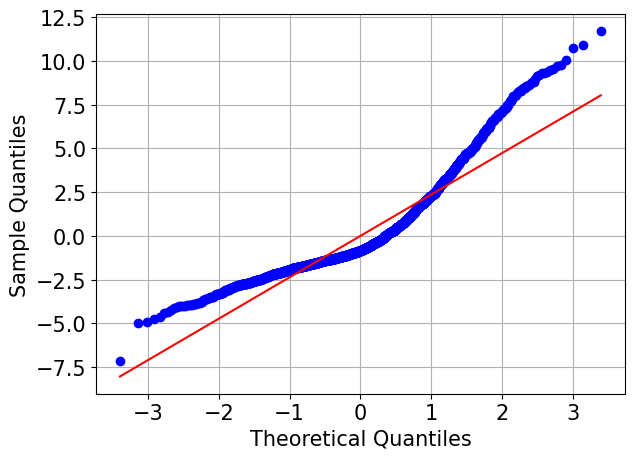

In [22]:
significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data_only_distance(country, save = False)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")


   
  
#plt.figure(figsize=(8, 6))
q_q_plot(all_residuals, "_median")

Worse fit of the Q-Q plot for median.

# Linear Regression Country-wise using all (not religion) (mean)

In [23]:
significant_countries = []
non_significant_countries = []
all_residuals = []

for country in participant_countries:
    country_code, p_value, coefficient, residuals = analyze_country_data(country)

    all_residuals.extend(residuals)

    if p_value < 0.05 / len(participant_countries):
        significant_countries.append((country_code, p_value, coefficient))
    else:
        non_significant_countries.append((country_code, p_value, coefficient))

significant_countries.sort(key=lambda x: x[1])
non_significant_countries.sort(key=lambda x: x[1])

print(f"\nSignificant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")

print(f"\nNon-significant countries (p < {0.05 / len(participant_countries)}):")
for country, p_val, coefficient in non_significant_countries:
    print(f"{country}: p-value = {p_val:.6f} - coefficient = {coefficient:.6f}")





Significant countries (p < 0.0010638297872340426):
Estonia: p-value = 0.000649 - coefficient = -1.657935
Latvia: p-value = 0.001056 - coefficient = -1.731653

Non-significant countries (p < 0.0010638297872340426):
Montenegro: p-value = 0.001195 - coefficient = -1.757489
Georgia: p-value = 0.001336 - coefficient = -1.867327
North Macedonia: p-value = 0.002944 - coefficient = -1.626920
Croatia: p-value = 0.003256 - coefficient = -1.504263
Albania: p-value = 0.004377 - coefficient = -1.993096
Slovenia: p-value = 0.004453 - coefficient = -1.644187
Azerbaijan: p-value = 0.006812 - coefficient = -1.594996
Serbia: p-value = 0.006819 - coefficient = -1.982009
Bosnia and Herzegovina: p-value = 0.010176 - coefficient = -1.563504
Armenia: p-value = 0.023535 - coefficient = -1.494726
Czechia: p-value = 0.026514 - coefficient = 1.499927
Iceland: p-value = 0.035345 - coefficient = -0.736209
France: p-value = 0.040952 - coefficient = 0.923612
Belgium: p-value = 0.043048 - coefficient = 0.624075
Aust